In [61]:
import os
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import glob
import pathlib
from PIL import Image
from tensorflow.keras.preprocessing import image
from sklearn.model_selection import train_test_split
from tensorflow import keras
from keras.models import *
from keras.layers import *
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import backend as K
from keras.callbacks import ModelCheckpoint
from tensorflow.keras.activations import *
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.metrics import BinaryAccuracy, Precision, Recall

## Data Processing

In [62]:
img_row = 256
img_col = 256
img_chan = 3

SEED = 42
np.random.seed(SEED)
tf.random.set_seed(SEED)

def data_process(DIR, array, target_shape):

    for i in range(len(DIR)):
        temp_img=image.load_img(DIR[i], target_size=target_shape)
        img=image.img_to_array(temp_img)
        array[i]=img[:,:,0]/255.0

    array=np.expand_dims(array, axis=3)
    return array

def load_datasets(root_dir):
    images_dir=os.path.join(root_dir, 'images')
    masks_dir=os.path.join(root_dir, 'masks')

    images_file=os.listdir(images_dir)
    masks_file=os.listdir(masks_dir)

    images_file = sorted(images_file)
    masks_file = sorted(masks_file)

    images_path=[]

    for i in range(len(images_file)):
        images_path.append(os.path.join(images_dir, images_file[i]))

    masks_path=[]

    for i in range(len(masks_file)):
        masks_path.append(os.path.join(masks_dir, masks_file[i]))

    target_shape = (img_row, img_col, img_chan)
    num_imgs=len(images_path)

    image_arr=np.zeros((num_imgs, img_row, img_col))
    mask_arr=np.zeros_like(image_arr)

    images = data_process(images_path, image_arr, target_shape)
    masks = data_process(masks_path, mask_arr, target_shape)

    train_images, val_images, train_masks, val_masks = train_test_split(images, masks, test_size=0.2, random_state=SEED)
    val_images, test_images, val_masks, test_masks = train_test_split(val_images, val_masks, test_size=0.01, random_state=SEED)

    df = pd.DataFrame({
        'Data': ['Train', 'Val', 'Test'],
        'Images': [len(train_images), len(val_images), len(test_images)],
        'Masks':[len(train_masks), len(val_masks), len(test_masks)]
    })

    display(df)
    return train_images, val_images, test_images, train_masks, val_masks, test_masks


### 1/ Covid-19 Dataset

In [63]:
covid_train_images, covid_val_images, covid_test_images, covid_train_masks, covid_val_masks, covid_test_masks = load_datasets(root_dir="./COVID-19/COVID")

,Data,Images,Masks
0,Train,2892,2892
1,Val,716,716
2,Test,8,8


### 2/ Pneumonia Datasets

In [64]:
vp_train_images, vp_val_images, vp_test_images, vp_train_masks, vp_val_masks, vp_test_masks = load_datasets(root_dir="./COVID-19/Viral Pneumonia")

,Data,Images,Masks
0,Train,1076,1076
1,Val,266,266
2,Test,3,3


## Model Implementation

In [65]:
def build_model(start_neurons):

    input_layer = Input((256, 256, 1))

    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(input_layer)
    conv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(conv1)
    pool1 = MaxPooling2D((2, 2))(conv1)
    pool1 = Dropout(0.25)(pool1)

    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(pool1)
    conv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(conv2)
    pool2 = MaxPooling2D((2, 2))(conv2)
    pool2 = Dropout(0.5)(pool2)

    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(pool2)
    conv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(conv3)
    pool3 = MaxPooling2D((2, 2))(conv3)
    pool3 = Dropout(0.5)(pool3)

    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(pool3)
    conv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(conv4)
    pool4 = MaxPooling2D((2, 2))(conv4)
    pool4 = Dropout(0.5)(pool4)

    # Middle
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(pool4)
    convm = Conv2D(start_neurons * 16, (3, 3), activation="relu", padding="same")(convm)

    deconv4 = Conv2DTranspose(start_neurons * 8, (3, 3), strides=(2, 2), padding="same")(convm)
    uconv4 = concatenate([deconv4, conv4])
    uconv4 = Dropout(0.5)(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)
    uconv4 = Conv2D(start_neurons * 8, (3, 3), activation="relu", padding="same")(uconv4)

    deconv3 = Conv2DTranspose(start_neurons * 4, (3, 3), strides=(2, 2), padding="same")(uconv4)
    uconv3 = concatenate([deconv3, conv3])
    uconv3 = Dropout(0.5)(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)
    uconv3 = Conv2D(start_neurons * 4, (3, 3), activation="relu", padding="same")(uconv3)

    deconv2 = Conv2DTranspose(start_neurons * 2, (3, 3), strides=(2, 2), padding="same")(uconv3)
    uconv2 = concatenate([deconv2, conv2])
    uconv2 = Dropout(0.5)(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)
    uconv2 = Conv2D(start_neurons * 2, (3, 3), activation="relu", padding="same")(uconv2)

    deconv1 = Conv2DTranspose(start_neurons * 1, (3, 3), strides=(2, 2), padding="same")(uconv2)
    uconv1 = concatenate([deconv1, conv1])
    uconv1 = Dropout(0.5)(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)
    uconv1 = Conv2D(start_neurons * 1, (3, 3), activation="relu", padding="same")(uconv1)

    output_layer = Conv2D(1, (1,1), padding="same", activation="sigmoid")(uconv1)

    model=Model(inputs=input_layer, outputs=output_layer)

    return model

In [66]:
def get_loss(history):
    fig = plt.figure(figsize = (10,10))
    plt.subplot(2,2,1)
    plt.plot(history.history["loss"], label = "training loss")
    plt.plot(history.history["val_loss"], label = "validation loss")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Entropy crusade binary")

    plt.subplot(2,2,2)
    plt.plot(history.history["dice_coef"], label = "training dice coefficient")
    plt.plot(history.history["val_dice_coef"], label = "validation dice coefficient")
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("Cofficient Dice Score")

In [67]:
def get_metrics(metrics):
    metric = pd.read_csv(metrics)

    accuracy = metric.iloc[:,1].mean()
    precision = metric.iloc[:,5].mean()
    recall = metric.iloc[:,6].mean()
    dice = metric.iloc[:,2].mean()
    iou = metric.iloc[:,3].mean()

    df = pd.DataFrame({
        'Metrics': ['Accuracy', 'Precision', 'Recall', 'Dice Coef', 'IoU'],
        'Values': [accuracy, precision, recall, dice, iou]
    })

    display(df)

In [68]:
def dice_coef(y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    return (2. * intersection + 1) / (K.sum(y_true_f) + K.sum(y_pred_f) + 1)

def iou_cal (y_true, y_pred):
    y_true_f = K.flatten(y_true)
    y_pred_f = K.flatten(y_pred)
    intersection = K.sum(y_true_f * y_pred_f)
    union = K.sum(y_true_f) + K.sum(y_pred_f) - intersection
    return intersection/union

def dice_coef_loss(y_true, y_pred):
    return -dice_coef(y_true, y_pred)

In [69]:
def train_model (train_images, val_images, train_masks, val_masks, csv_file):
    csv_logger = tf.keras.callbacks.CSVLogger(csv_file)
    early_stop = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=10)

    model=build_model(16)
    model.compile(optimizer=Adam(learning_rate=5*1e-4), loss="binary_crossentropy",
                    metrics=[BinaryAccuracy, Precision, Recall, dice_coef, iou_cal])

    history = model.fit(x = train_images,
                        y = train_masks,
                        validation_data = (val_images, val_masks),
                        epochs = 20,
                        batch_size = 10,
                        callbacks=[csv_logger, early_stop])

    get_metrics(csv_file)
    get_loss (history=history)
    return model

### 1/ Covid-19 Dataset

Epoch 1/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 101s 333ms/step - binary_accuracy: 0.7789 - dice_coef: 0.3431 - iou_cal: 0.2139 - loss: 0.4799 - precision_4: 0.5957 - recall_4: 0.1066 - val_binary_accuracy: 0.9265 - val_dice_coef: 0.7735 - val_iou_cal: 0.6313 - val_loss: 0.2009 - val_precision_4: 0.8116 - val_recall_4: 0.9132
Epoch 2/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 96s 332ms/step - binary_accuracy: 0.9411 - dice_coef: 0.8178 - iou_cal: 0.6937 - loss: 0.1519 - precision_4: 0.9048 - recall_4: 0.8459 - val_binary_accuracy: 0.9589 - val_dice_coef: 0.8650 - val_iou_cal: 0.7627 - val_loss: 0.1136 - val_precision_4: 0.9010 - val_recall_4: 0.9358
Epoch 3/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 91s 315ms/step - binary_accuracy: 0.9616 - dice_coef: 0.8812 - iou_cal: 0.7884 - loss: 0.0995 - precision_4: 0.9336 - recall_4: 0.9059 - val_binary_accuracy: 0.9698 - val_dice_coef: 0.9055 - val_iou_cal: 0.8277 - val_loss: 0.0784 - val_precision_4: 0.9218 - val_recall_4: 0.9585
Epoch 4/20
290/290 ━━━━━━━━━━━━━━━━━━━━ 90

,Metrics,Values
0,Accuracy,0.972913
1,Precision,0.960044
2,Recall,0.924565
3,Dice Coef,0.918009
4,IoU,0.862703


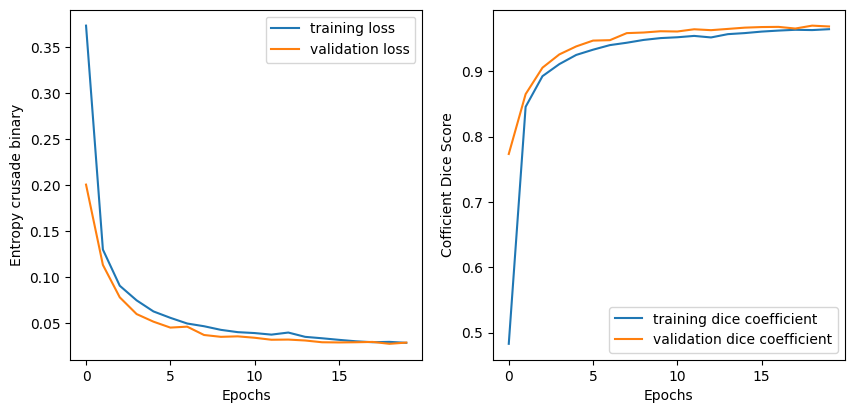

In [70]:
covid_model = train_model(covid_train_images, covid_val_images, covid_train_masks, covid_val_masks, './results/covid_unet.csv')

### 2/ Pneumonia Datasets

Epoch 1/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 43s 352ms/step - binary_accuracy: 0.7499 - dice_coef: 0.2773 - iou_cal: 0.1616 - loss: 0.5662 - precision_5: 0.2184 - recall_5: 0.0294 - val_binary_accuracy: 0.7744 - val_dice_coef: 0.4248 - val_iou_cal: 0.2697 - val_loss: 0.3953 - val_precision_5: 0.7202 - val_recall_5: 0.0746
Epoch 2/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 40s 373ms/step - binary_accuracy: 0.8690 - dice_coef: 0.5914 - iou_cal: 0.4293 - loss: 0.2924 - precision_5: 0.7966 - recall_5: 0.5774 - val_binary_accuracy: 0.9385 - val_dice_coef: 0.7280 - val_iou_cal: 0.5734 - val_loss: 0.1757 - val_precision_5: 0.9551 - val_recall_5: 0.7763
Epoch 3/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s 330ms/step - binary_accuracy: 0.9479 - dice_coef: 0.8265 - iou_cal: 0.7056 - loss: 0.1385 - precision_5: 0.9097 - recall_5: 0.8613 - val_binary_accuracy: 0.9177 - val_dice_coef: 0.6928 - val_iou_cal: 0.5313 - val_loss: 0.2166 - val_precision_5: 0.9432 - val_recall_5: 0.6934
Epoch 4/20
108/108 ━━━━━━━━━━━━━━━━━━━━ 36s

,Metrics,Values
0,Accuracy,0.960564
1,Precision,0.911645
2,Recall,0.879875
3,Dice Coef,0.877297
4,IoU,0.802995


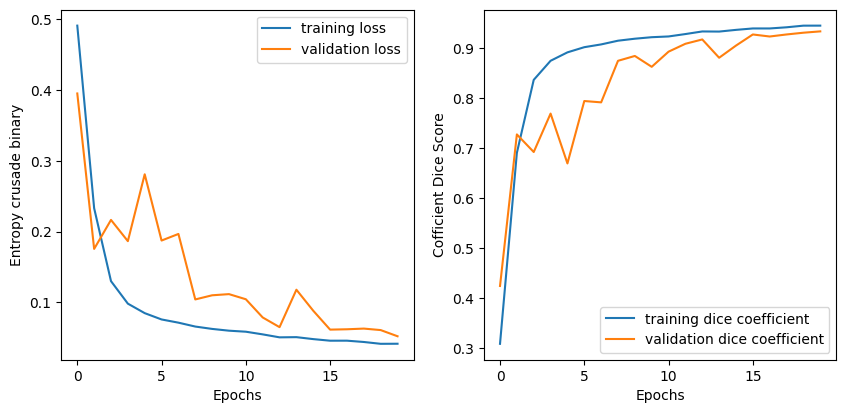

In [71]:
vp_model = train_model(vp_train_images, vp_val_images, vp_train_masks, vp_val_masks, './results/pneumonia_unet.csv')

## Results Illustration

In [82]:
def prediction_illustration(model, test_images, test_masks):
    img_side_size = 256

    for img_num in range(len(test_images)):
        pred = model.predict(test_images[img_num].reshape(1,img_side_size,img_side_size,1))
        pred[pred>0.5] = 1.0
        pred[pred<0.5] = 0.0
        fig = plt.figure(figsize = (15,10))

        plt.subplot(1,4,1)
        plt.imshow(test_images[img_num].reshape(img_side_size, img_side_size), cmap = "gray")
        plt.title("Test Image")

        plt.subplot(1,4,2)
        plt.imshow(test_masks[img_num].reshape(img_side_size, img_side_size), cmap = "Blues")
        plt.title("True Mask")

        plt.subplot(1,4,3)
        plt.imshow(pred.reshape(img_side_size, img_side_size), cmap = "Blues")
        plt.title("Predicted Mask")

### 1/ Covid-19 Datasets

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 41ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


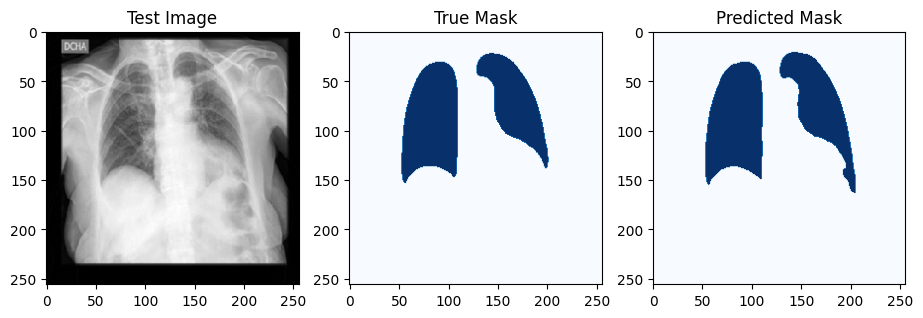

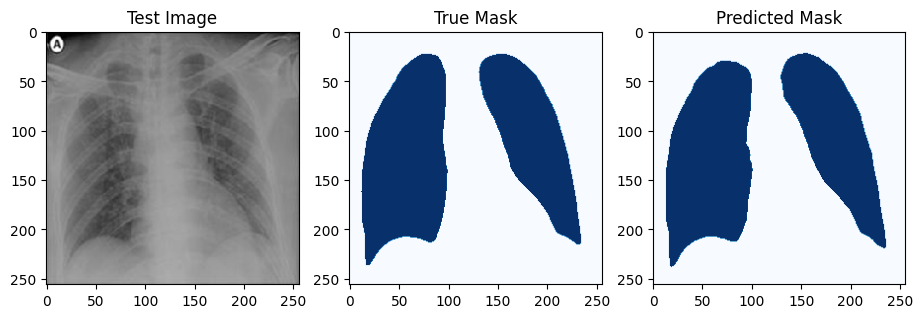

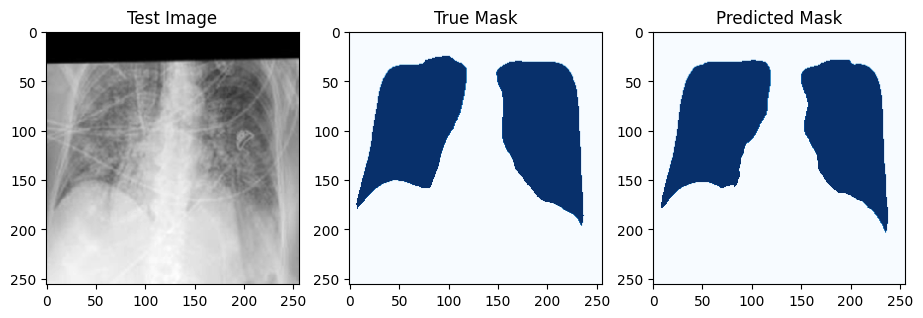

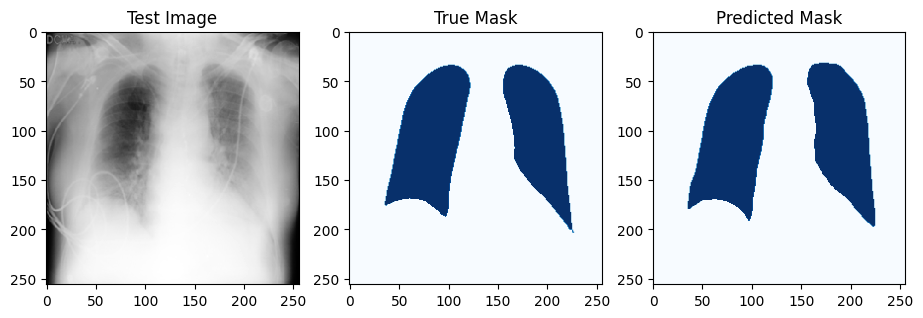

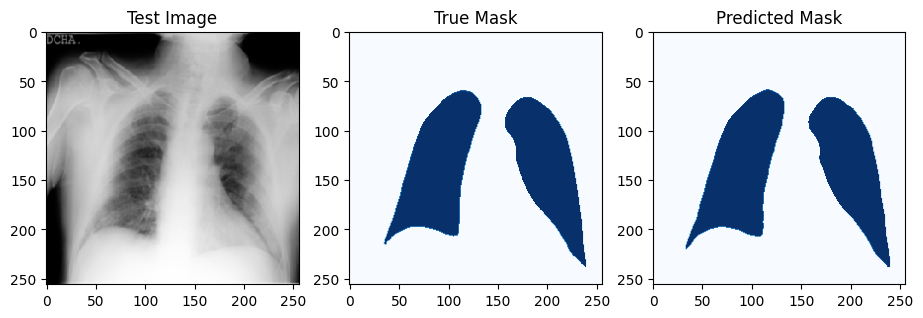

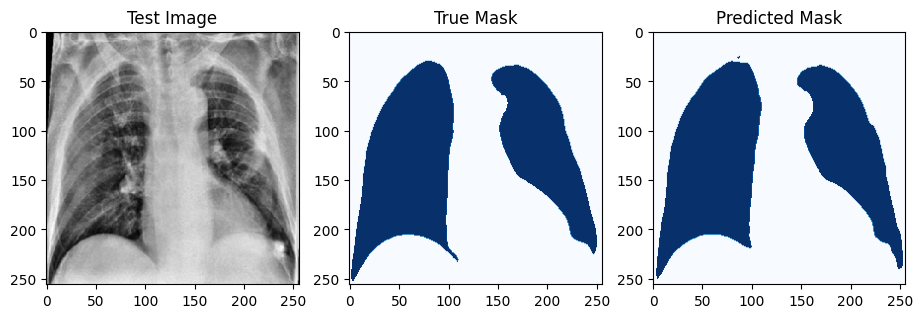

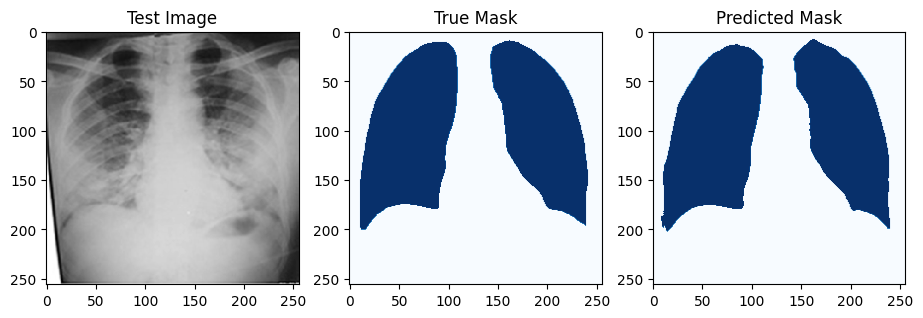

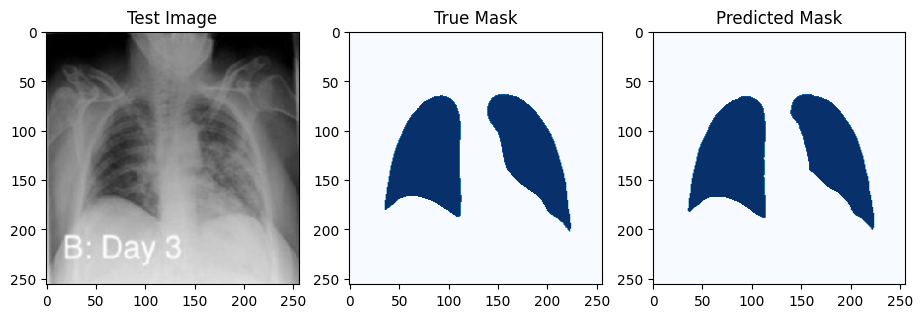

In [83]:
prediction_illustration(covid_model, covid_test_images, covid_test_masks)

### 2/ Pneumonia Datasets

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 40ms/step


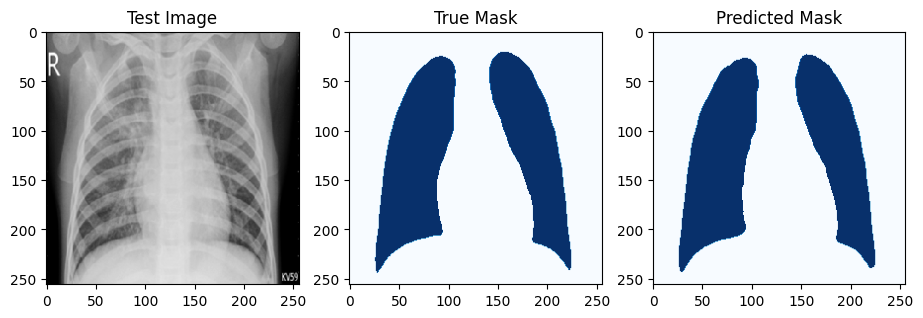

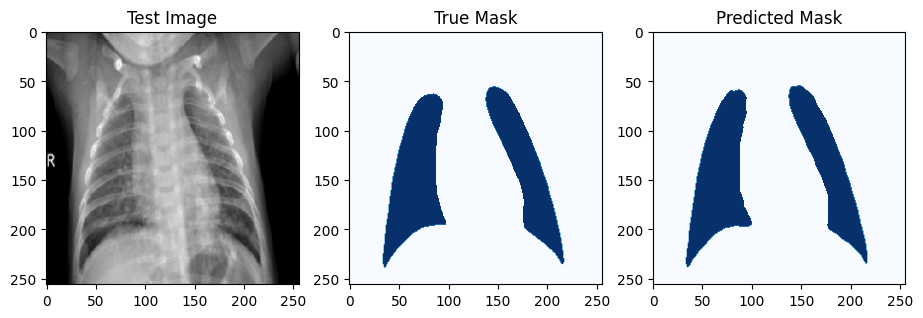

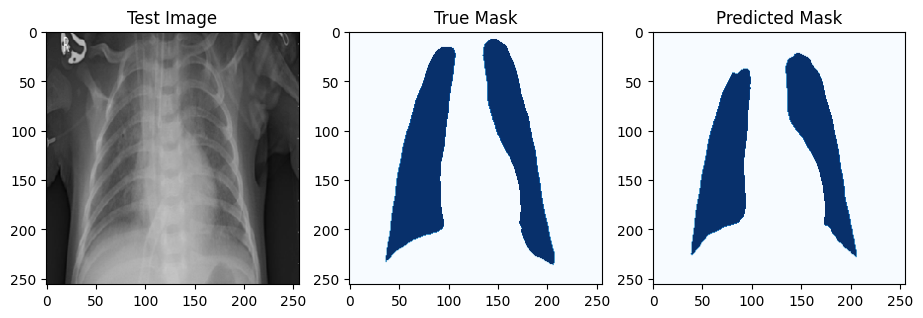

In [79]:
prediction_illustration(vp_model, vp_test_images, vp_test_masks)